### Obtención de datos desde The Dog API

Los datos fueron obtenidos mediante una solicitud HTTP al endpoint `/v1/breeds` de The Dog API.
Dado que la API requiere autenticación, se incluyó una API Key utilizando headers en la petición
(`x-api-key`), siguiendo las buenas prácticas recomendadas por la documentación oficial.

Por motivos de seguridad, la clave de acceso no se incluye directamente en el código y se gestiona
mediante una variable de entorno.

In [75]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from collections import Counter
from getpass import getpass


In [ ]:
#Variables de entorno
os.environ["DOG_API_KEY"] = "Tu_API_Key_Aqui"

In [77]:
# Obtener datos de la API de The Dog API
url = "https://api.thedogapi.com/v1/breeds"

API_KEY = os.getenv("DOG_API_KEY")

headers = {
    "x-api-key": API_KEY 
}

response = requests.get(url, headers=headers)
data = response.json()

df = pd.DataFrame(data)
df.head()

,id,name,species_id,life_span,temperament,origin,country_codes,country_code,description,bred_for,perfect_for,breed_group,history,reference_image_id,weight,height,image
0,1,Affenpinscher,2,12-15,"Confident, alert, playful, loyal, courageous",Germany,DE,DE,"Small, sturdy toy breed with a distinctive mon...",None,None,Toy,"Originating in 17th-century Germany, bred down...",uaRTIWL69C,"{'imperial': '7-10', 'metric': '3.2-4.5'}","{'imperial': '9-11.5', 'metric': '23-29'}","{'id': 'uaRTIWL69C', 'url': 'https://storage.g..."
1,2,Afghan Hound,2,12-15,"Independent, dignified, aloof, loyal, confident",Afghanistan,AF,AF,"Ancient, elegant sighthound with dramatic, flo...",None,None,Hound,Ancient sighthound originating in the mountain...,atummvxJRT,"{'imperial': 'Male: 55-65; Female: 45-55', 'me...","{'imperial': 'Male: 27-29; Female: 25-27', 'me...","{'id': 'atummvxJRT', 'url': 'https://storage.g..."
2,4,Airedale Terrier,2,11-14,"Confident, intelligent, courageous, alert, ene...","Yorkshire, England",GB,GB,"The largest of all terrier breeds, the Airedal...",None,None,Terrier,"Developed in the Aire Valley of Yorkshire, Eng...",H5dFqyAoeZ,"{'imperial': 'Male: 50-70; Female: 40-55', 'me...","{'imperial': 'Male: 23-24; Female: 22-23', 'me...","{'id': 'H5dFqyAoeZ', 'url': 'https://cdn4.thed..."
3,5,Akbash,2,10-12,"Independent, protective, calm, alert, loyal, i...",Western Turkey,TR,TR,"Large, powerful, all-white livestock guardian ...",None,None,Guardian,"Ancient breed developed over 3,000 years ago i...",e8yVyPMX2w,"{'imperial': 'Male: 90-140; Female: 75-105', '...","{'imperial': 'Male: 28-34; Female: 27-32', 'me...","{'id': 'e8yVyPMX2w', 'url': 'https://cdn4.thed..."
4,6,Akita,2,10-13,"Courageous, loyal, dignified, independent, pro...",Japan,JP,JP,"A large, powerful spitz-type dog of Japanese o...",None,None,Working,Ancient Japanese breed developed in the mounta...,t5MVw1i9DV,"{'imperial': 'Male: 100-130; Female: 70-100', ...","{'imperial': 'Male: 26-28; Female: 24-26', 'me...","{'id': 't5MVw1i9DV', 'url': 'https://storage.g..."


A partir de una inspección inicial de los datos utilizando `head()`, se observa que el dataset
contiene información relevante como el nombre de la raza, la esperanza de vida (`life_span`)
y el temperamento.

También se identifica que algunas variables clave se encuentran en formato texto, lo cual
requiere un proceso de limpieza y transformación antes de su análisis.

In [78]:
# Limpieza y feature engineering
# helper: parse a range-like string and return min, max, mean
def parse_range_to_stats(s):
    if pd.isna(s):
        return (np.nan, np.nan, np.nan)
    nums = re.findall(r"\d+(?:\.\d+)?", str(s))
    nums = list(map(float, nums))
    if not nums:
        return (np.nan, np.nan, np.nan)
    if len(nums) == 1:
        return (nums[0], nums[0], nums[0])
    return (min(nums), max(nums), sum(nums) / len(nums))

# peso: preferir campo 'weight' -> 'metric' si existe
def get_metric_str(d):
    if isinstance(d, dict):
        return d.get('metric') or d.get('imperial')
    return d

# aplicar parsing de peso y altura
df['weight_metric_raw'] = df['weight'].apply(get_metric_str)
df[['weight_min','weight_max','weight_mean']] = df['weight_metric_raw'].apply(lambda s: pd.Series(parse_range_to_stats(s)))

df['height_metric_raw'] = df['height'].apply(get_metric_str)
df[['height_min','height_max','height_mean']] = df['height_metric_raw'].apply(lambda s: pd.Series(parse_range_to_stats(s)))

# esperanza de vida (recalcular de forma robusta)
if 'life_span_avg' not in df.columns:
    df[['life_min','life_max','life_mean']] = df['life_span'].apply(lambda s: pd.Series(parse_range_to_stats(s)))
else:
    # si ya existe life_span_avg, usarlo como life_mean y completar min/max
    df['life_mean'] = df['life_span'].apply(lambda s: parse_range_to_stats(s)[2] if pd.notna(s) else np.nan)
    df[['life_min','life_max']] = df['life_span'].apply(lambda s: pd.Series(parse_range_to_stats(s)[:2]))

# tamaño categórico basado en percentiles de weight_mean
q33, q66 = df['weight_mean'].dropna().quantile([0.33, 0.66]) if df['weight_mean'].dropna().size > 0 else (np.nan, np.nan)
def size_category(w):
    if pd.isna(w):
        return 'unknown'
    if w <= q33:
        return 'small'
    elif w <= q66:
        return 'medium'
    else:
        return 'large'

df['size_cat'] = df['weight_mean'].apply(size_category)

# temperamento: lista y conteo de temperamentos
df['temperament_list'] = df['temperament'].dropna().apply(lambda s: [t.strip() for t in s.split(',')])
all_temps = [t for sub in df['temperament_list'].dropna() for t in sub]
from collections import Counter
temperament_counts = Counter(all_temps)

print("Limpieza completada. Filas:", df.shape[0])
print("Temperamentos top 10:", temperament_counts.most_common(10))

Limpieza completada. Filas: 169
Temperamentos top 10: [('intelligent', 101), ('loyal', 85), ('alert', 78), ('energetic', 67), ('affectionate', 50), ('playful', 48), ('courageous', 41), ('confident', 37), ('Intelligent', 33), ('protective', 30)]


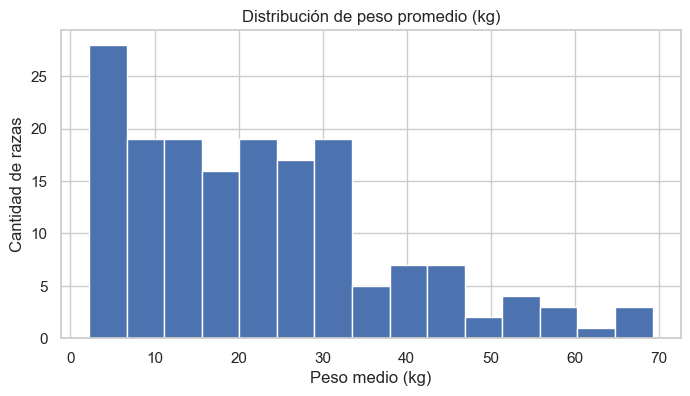

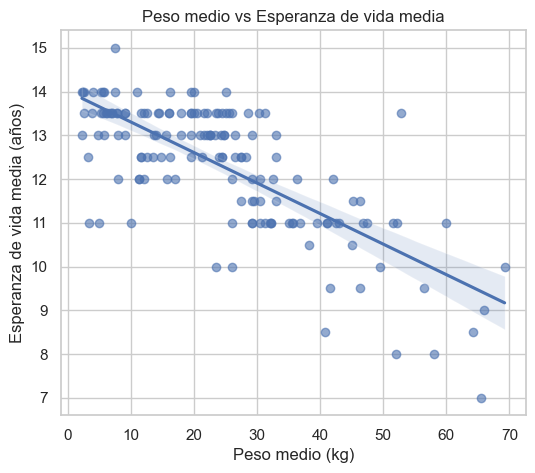

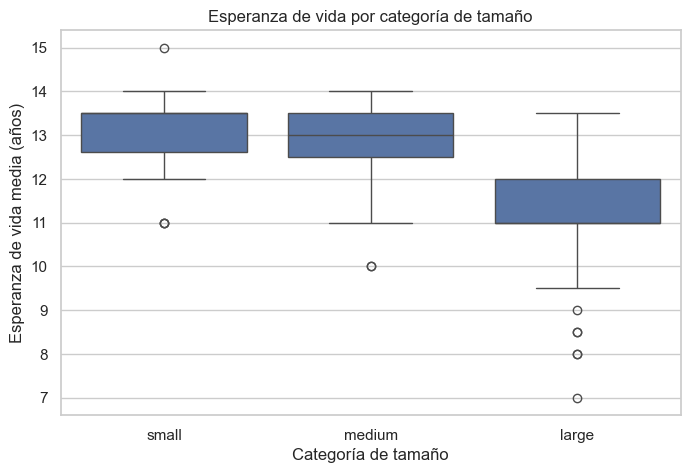

In [79]:
# EDA: 3 visualizaciones rápidas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(8,4))
plt.hist(df['weight_mean'].dropna(), bins=15)
plt.title('Distribución de peso promedio (kg)')
plt.xlabel('Peso medio (kg)')
plt.ylabel('Cantidad de razas')
# Guardar gráfico para documentación
plt.savefig("../images/peso_vs_vida(barras).png", dpi=300)
plt.show()

plt.figure(figsize=(6,5))
sns.regplot(x='weight_mean', y='life_mean', data=df, scatter_kws={'alpha':0.6})
plt.title('Peso medio vs Esperanza de vida media')
plt.xlabel('Peso medio (kg)')
plt.ylabel('Esperanza de vida media (años)')
# Guardar gráfico para documentación
plt.savefig("../images/peso_vs_vida(dispersion).png", dpi=300)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='size_cat', y='life_mean', data=df, order=['small','medium','large'])
plt.title('Esperanza de vida por categoría de tamaño')
plt.xlabel('Categoría de tamaño')
plt.ylabel('Esperanza de vida media (años)')
# Guardar gráfico para documentación
plt.savefig("../images/vida_por_tamano.png", dpi=300)
plt.show()

### Distribución del peso promedio (histograma)
La distribución del peso promedio muestra que la mayoría de las razas de perros se concentra en
rangos de peso bajos, especialmente por debajo de los 30 kg. A medida que el peso aumenta, la
frecuencia de razas disminuye considerablemente, lo que indica que las razas de gran tamaño
son menos comunes dentro del dataset.

### Peso medio vs esperanza de vida media (dispersión)
El gráfico de dispersión evidencia una relación inversa entre el peso promedio y la esperanza de
vida media. En general, las razas de menor peso tienden a vivir más años, mientras que las razas
de mayor peso presentan una menor esperanza de vida y una mayor variabilidad en sus valores.

### Esperanza de vida por categoría de tamaño (boxplot)
El análisis por categoría de tamaño refuerza la tendencia observada previamente. Las razas
clasificadas como pequeñas presentan una mayor esperanza de vida mediana, seguidas por las
razas medianas. En contraste, las razas grandes muestran una menor esperanza de vida y una
mayor dispersión de los datos, incluyendo varios valores atípicos.

In [80]:
# Guardar datos limpios
out_path = os.path.join('..', 'data', 'breeds_clean.csv')
df.to_csv(out_path, index=False)
print('Datos limpios guardados en:', out_path)

Datos limpios guardados en: ..\data\breeds_clean.csv


Inicialmente se obtuvo un error 403 debido a falta de autenticación, el cual se resolvió mediante el uso de una API Key provista por The Dog API

A partir de una inspección inicial de los datos utilizando `head()`, se observa que el dataset
contiene información relevante como el nombre de la raza, la esperanza de vida (`life_span`)
y el temperamento.

También se identifica que algunas variables clave se encuentran en formato texto, lo cual
requiere un proceso de limpieza y transformación antes de su análisis.


In [81]:
# exploración inicial de los datos
df.info()
df.isnull().sum()
df[['life_span', 'temperament']].head()
df.shape

<class 'pandas.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  169 non-null    str    
 1   name                169 non-null    str    
 2   species_id          169 non-null    str    
 3   life_span           150 non-null    str    
 4   temperament         169 non-null    str    
 5   origin              169 non-null    str    
 6   country_codes       169 non-null    str    
 7   country_code        169 non-null    str    
 8   description         169 non-null    str    
 9   bred_for            0 non-null      object 
 10  perfect_for         0 non-null      object 
 11  breed_group         169 non-null    str    
 12  history             169 non-null    str    
 13  reference_image_id  169 non-null    str    
 14  weight              169 non-null    object 
 15  height              169 non-null    object 
 16  image              

(169, 30)

El dataset contiene información de 169 razas de perros. Las variables más relevantes para este análisis son life_span y temperament. Se identificaron valores nulos y formatos no estructurados que requieren limpieza

In [82]:
# Análisis de la esperanza de vida promedio
def avg_life_span(value):
    if pd.isna(value):
        return None
    numbers = re.findall(r'\d+', value)
    numbers = list(map(int, numbers))
    return sum(numbers) / len(numbers)

df['life_span_avg'] = df['life_span'].apply(avg_life_span)

La esperanza de vida se encontraba en formato texto, por lo que se transformó a un valor numérico promedio para permitir su análisis

In [83]:
# Análisis de temperamentos
temperaments = df['temperament'].dropna().str.split(', ')
all_temperaments = [t for sublist in temperaments for t in sublist]

temperament_counts = Counter(all_temperaments)


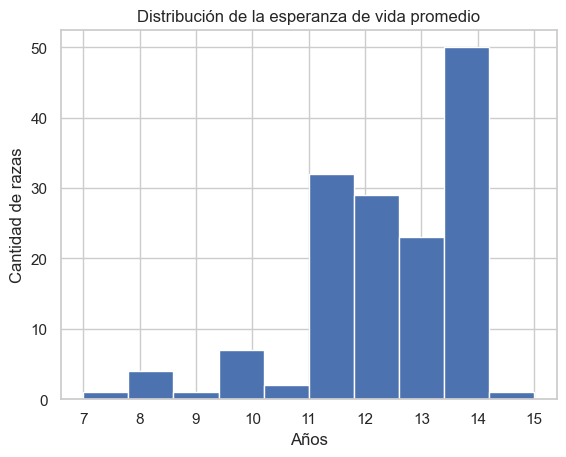

In [84]:
# Visualización de la distribución de la esperanza de vida promedio
plt.hist(df['life_span_avg'].dropna(), bins=10)
plt.title("Distribución de la esperanza de vida promedio")
plt.xlabel("Años")
plt.ylabel("Cantidad de razas")
# Guardar gráfico para documentación
plt.savefig("../images/cantidad_razas_vs_vida.png", dpi=300)
plt.show()

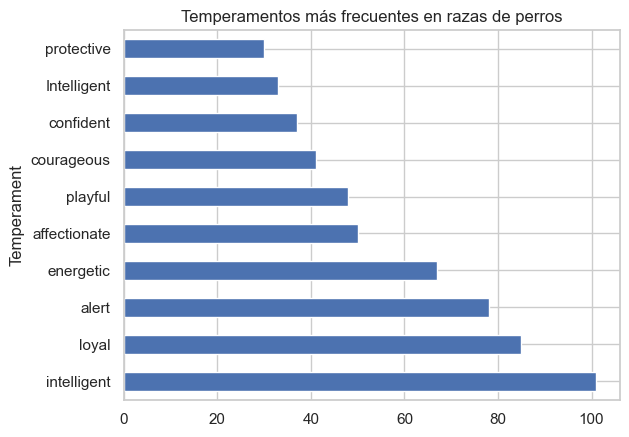

In [85]:
# Visualización de los temperamentos más frecuentes
top_temperaments = pd.DataFrame(temperament_counts.most_common(10),columns=['Temperament', 'Count'])

top_temperaments.plot(kind='barh', x='Temperament', y='Count', legend=False)
plt.title("Temperamentos más frecuentes en razas de perros")
# Guardar gráfico para documentación
plt.savefig("../images/Temperamentos_Frecuentes.png", dpi=300)
plt.show()

Conclusión 1:
La esperanza de vida más frecuente entre las razas de perros se encuentra alrededor de los 11–14 años, lo que indica que la mayoría de las razas comparten una longevidad similar.

Conclusión 2:
El temperamento más frecuente es intelligent, seguido por “Loyal” y “alert”, lo que sugiere que la crianza histórica de los perros prioriza la sociabilidad con humanos.